# Exercise-3: Regularization with Alpha Dropout and MC Dropout

Using the MNIST dataset, extend the previously trained deep neural network by applying Alpha Dropout. Then, without retraining, use Monte Carlo (MC) Dropout at inference to estimate if you can achieve better accuracy. Set random seeds to 42. Use the following configuration:

- Flatten input images to 28 × 28 = 784 features
- 3 hidden layers, 64 neurons each
- SELU activation function (required for Alpha Dropout)
- LeCun normal initialization
- Alpha Dropout rate: 0.1 in all hidden layers
- Output layer: 10 neurons with softmax
- Optimizer: Nadam
- learning_rate = 0.001, loss=sparse_categorical_crossentropy
- epochs = 50, batch_size = 32
- Use only the first 1000 training samples and first 200 test samples
- For MC Dropout, enable dropout during inference and average predictions over 20 stochastic forward passes

## Q3.1 Report the test accuracy of the network with Alpha Dropout applied during training.

In [9]:
from tensorflow.keras.layers import Dense, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.datasets import mnist


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds to 42
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
loss_function = 'sparse_categorical_crossentropy'
output_activation = 'softmax'
initializer = 'lecun_normal'
learning_rate = 0.001
hidden_neurons = 64
output_neurons = 10
activation = 'selu'
hidden_layers = 3
dropout_rate = 0.1
batch_size = 32
epochs = 50
mc_iterations = 20

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Use only the first 1000 training samples and first 200 test samples
x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:200]
y_test = y_test[:200]

# Preprocess the data - flatten and normalize
x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.0

# Build the model
model = Sequential()

# First hidden layer with input shape and alpha Dropout
model.add(Dense(hidden_neurons, activation=activation, kernel_initializer=initializer, 
                input_shape=(28 * 28,)))
model.add(AlphaDropout(dropout_rate))

# Remaining hidden layers with Alpha Dropout
for _ in range(hidden_layers - 1):
    model.add(Dense(hidden_neurons, activation=activation, kernel_initializer=initializer))
    model.add(AlphaDropout(dropout_rate))

# Output layer
model.add(Dense(output_neurons, activation=output_activation))
# Compile the model
optimizer = Nadam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                     patience=5, 
                     restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[early_stopping],
                    validation_split=0.2,
                    verbose=1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

# Save the model
save_model(model, 'models/exercise_3_model.keras')


Epoch 1/50


/opt/miniconda3/envs/envAssignments/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2438 - loss: 2.1804 - val_accuracy: 0.7300 - val_loss: 1.0059
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5113 - loss: 1.4561 - val_accuracy: 0.8000 - val_loss: 0.6654
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6837 - loss: 0.9770 - val_accuracy: 0.8350 - val_loss: 0.5816
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7350 - loss: 0.7749 - val_accuracy: 0.8500 - val_loss: 0.5689
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7937 - loss: 0.5976 - val_accuracy: 0.8300 - val_loss: 0.5703
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8150 - loss: 0.5687 - val_accuracy: 0.8450 - val_loss: 0.5843
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8325 - loss: 0.5091 - val_accuracy: 0.8650 - val_loss: 0.5716
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8512 - loss: 0.4162 - val_accuracy: 0.8400 - val_loss: 0.6111
Epo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


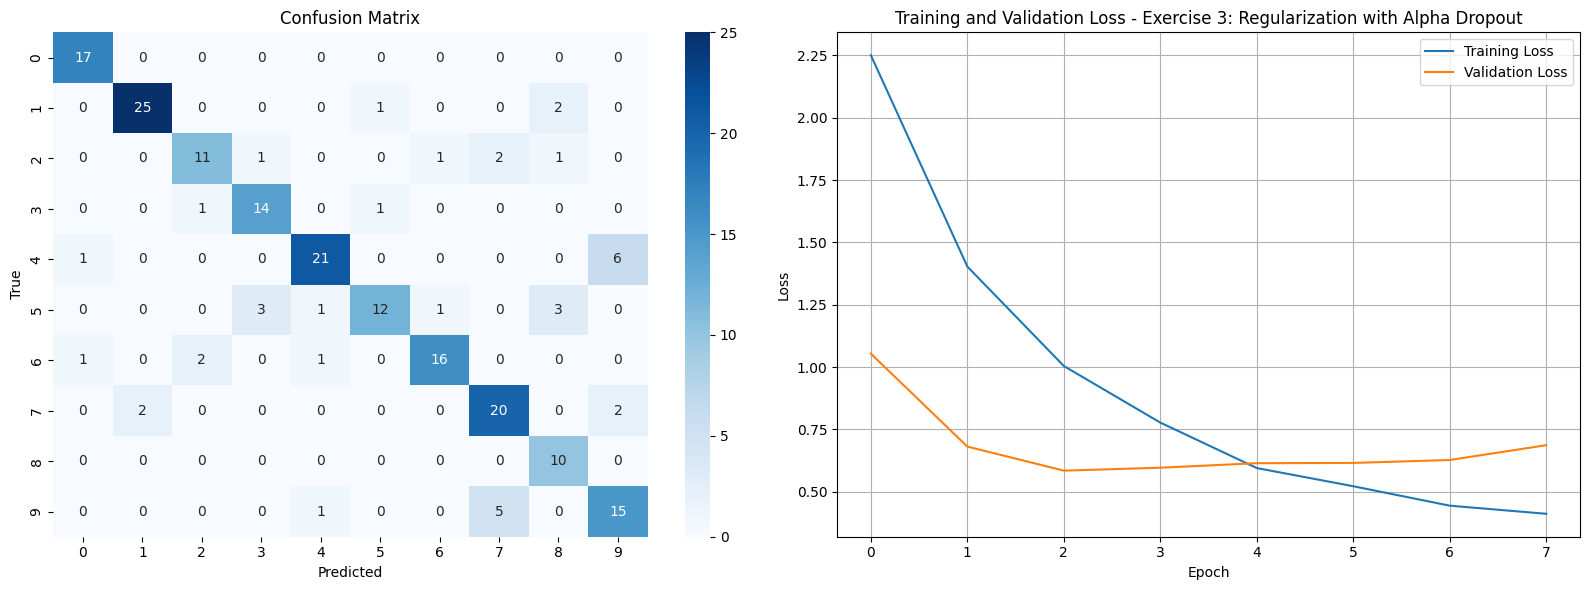

In [8]:
from helper import plot_model_evaluation

# Plot model evaluation
plot_model_evaluation(model, x_test, y_test, history, exercise_title='Exercise 3: Regularization with Alpha Dropout')

## Q3.2 Report the MC Dropout-enhanced accuracy (averaging 20 stochastic predictions).

In [11]:
from tensorflow.keras.models import load_model

model = load_model('models/exercise_3_model.keras')

mc_predictions = []
# See configuration above for mc_iterations
for i in range(mc_iterations):
    # Use training=True to enable dropout during inference
    predictions = model(x_test, training=True)
    # Collect predictions
    mc_predictions.append(predictions.numpy())

# Average predictions across all MC iterations
mc_predictions = np.array(mc_predictions)
mc_mean_predictions = np.mean(mc_predictions, axis=0)

# Get predicted classes from averaged predictions
mc_predicted_classes = np.argmax(mc_mean_predictions, axis=1)

# Calculate MC Dropout accuracy
mc_accuracy = np.mean(mc_predicted_classes == y_test)
print(f'Q3.2 MC Dropout-enhanced accuracy: {mc_accuracy * 100:.2f}%')

Q3.2 MC Dropout-enhanced accuracy: 84.50%


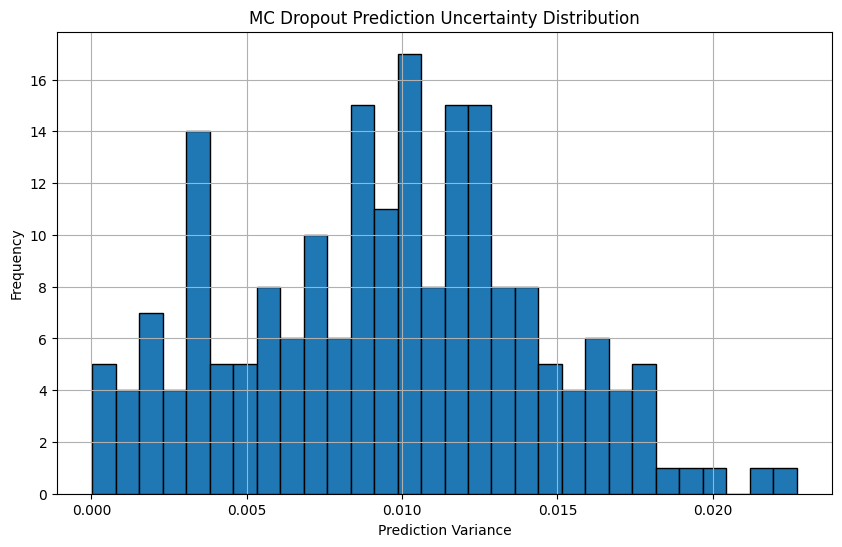

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
prediction_variance = np.var(mc_predictions, axis=0).mean(axis=1)
plt.hist(prediction_variance, bins=30, edgecolor='black')
plt.xlabel('Prediction Variance')
plt.ylabel('Frequency')
plt.title('MC Dropout Prediction Uncertainty Distribution')
plt.grid(True)
plt.show()

# Monte Carlo Dropout
The essence of Monte Carlo (MC) dropout is to embrace uncertainy and randomness, hence the name "Monte Carlo". 

During inference (the phase where a trained model is used to make predictions on new, unseen data), instead of turning off dropout (as is standard practice), we keep it active. This means that each time we pass an input through the network, different neurons are randomly dropped out, leading to a variety of outputs for the same input. 

This stochastic (randomized) behavior allows us to sample from the model's predictive distribution, and allows us to improve the model's performance by averaging these multiple predictions.

